In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import pandas as pd
import scipy.io
import scipy.optimize
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
subj_list_GA = ['GA01', 'GA02', 'GA05', 'GA07', 'GA08', 
                'GA11', 'GA12', 'GA13', 'GA14', 'GA15', 
                'GA18', 'GA19', 'GA20', 'GA21', 'GA23', 
                'GA26', 'GA27', 'GA28', 'GA29', 'GA30', 
                'GA31', 'GA32', 'GA33', 'GA34', 'GA35',
                'GA36', 'GA37', 'GA38', 'GA42', 'GA44'] 

In [4]:
subj_list_GD = ['GD07', 'GD11', 'GD30', 'GD02',# 'GD29',
                'GD32', 'GD23', 'GD01']

In [14]:
subj_list = subj_list_GD
#behav_dir = '/clmnlab/GD/behav_data'
behav_dir = '/clmnlab/GA/behavior_data/'

In [6]:
def test_day(i):
    switcher = {
        0:'refmri',
        1:'fmri.mat',
        2:'1-behav.mat',
        3:'2-behav.mat',
        4:'3-behav.mat',
        5:'4-behav.mat',
        6:'5-behav.mat',
        7:'refmri.mat'
    }
    return switcher.get(i,"Invalid day")
def set_y(subj):
    group = subj[1]
    if group == 'A':
        behav_datum = '/clmnlab/GA/behavior_data/mrew_errR_30_run1to3_20190626.mat'
        datum = scipy.io.loadmat(behav_datum)
        y = np.concatenate(datum['%s_mrew_all' %subj])
    elif group == 'D':
        y = calc_mrew('/clmnlab/GD/behav_data/%s-refmri.mat' %subj)[:3*8]
    return y

In [7]:
def exponential_fit(x, a, b, c):
    return a * (1 - np.exp(-b * x)) + c

In [8]:
def convert_ID(ID):
    x = np.int8(np.kron(np.ones(5),range(-2,3)))
    y = np.int8(np.kron(range(2,-3,-1),np.ones(5)))
    return (x[ID-1],y[ID-1])

In [9]:
def calc_mrew(behav_datum):

    datum = scipy.io.loadmat(behav_datum)
    nS = 300   ## Number of sample(=frame) of 1 trial for run 2~7
    nR = 7
    W = 1   ## Size of a time bin
    nbin = W*60;   ## number of frame per a second. aka, the 'bin' means a frame.

    end = datum['LearnTrialStartTime'].shape[1]
    startTime = datum['LearnTrialStartTime'][0,range(0,end,97)]
    cnt_hit_all = np.zeros((datum['targetID'].shape[1],nS))

    for i,ID in enumerate(np.concatenate(datum['targetID'])):
        pos = datum['boxSize']*convert_ID(ID)
        xy = datum['allXY'][:,nS*i:nS*(i+1)]
        err = xy - np.int16(np.ones((2,300))*pos.T)
        cnt_hit_all[i,:] = (abs(err[0,:]) <= datum['boxSize']*0.5) & (abs(err[1,:]) <= datum['boxSize']*0.5)
    assert np.sum(np.sum(cnt_hit_all,axis=1)-datum['cnt_hit'])==0
    print('Matched...')

    rew_bin = np.zeros((nR,int(300*97/nbin)))
    for r in range(nR):
        tem = cnt_hit_all[97*r:97*(r+1),:].reshape(nS*97,1)
        for i in range(int(300*97/nbin)):
            rew_bin[r,i] = sum(tem[nbin*i:nbin*(i+1)])
            
    ntrial = 12
    nblock = 8
    nrun = 7
    max_score =  nS*ntrial   ## 60Hz*5s*12trials = frames
    temp = rew_bin[:,5:].reshape(nrun*5*ntrial*nblock)
    norm_mrew = np.zeros(nblock*nrun)
    for i in range(nblock*nrun):
        norm_mrew[i] = sum(temp[5*ntrial*i:5*ntrial*(i+1)])/max_score
    
    return norm_mrew

In [15]:
mrew_data = {}

for subj in subj_list:
    #behav_datum = behav_dir + '/%s-refmri.mat' %subj
    #behav_datum = behav_dir + subj + '/%s-refmri.mat' %subj
    #mrew_data[subj] = calc_mrew(behav_datum)[:3*8]
    mrew_data[subj] = set_y(subj)

Matched...
Matched...
Matched...
Matched...
Matched...
Matched...
Matched...


In [16]:
df = pd.DataFrame(columns=['subj', 'x', 'y', 'run'])

for subj in subj_list:
    index = 0
    
    for i, y in enumerate(mrew_data[subj]):
        df = df.append({'subj': subj, 'x': float(index / 24), 'y': y, 'run': int(i // 24) + 1}, ignore_index=True)
        index += 1

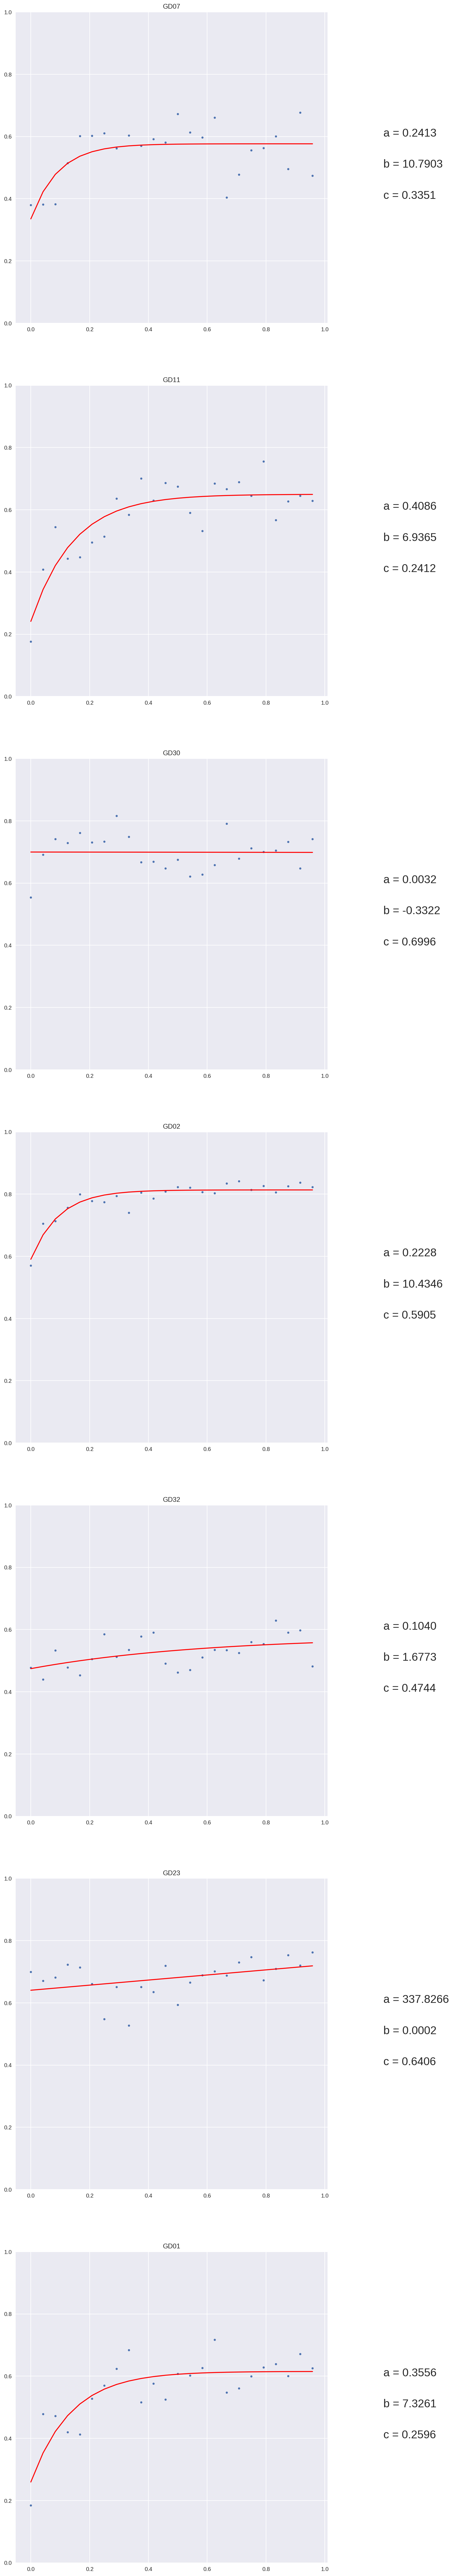

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 12*len(subj_list))
fit_results = []

for i, subj in enumerate(subj_list):
    
    sub_df = df[df['subj'] == subj]
    x = list(sub_df['x'])
    y = list(sub_df['y'])
    
    popt, pcov = scipy.optimize.curve_fit(exponential_fit, x, y)
    
    plt.subplot(len(subj_list), 1, i+1)
    plt.grid(True)
    plt.scatter(x, y, marker='.')
    plt.plot(x, exponential_fit(np.array(x), *popt), color='red')
    plt.title(subj)
    plt.text(1.2, 0.6, 'a = %.4f' % (popt[0]), fontsize=20)
    plt.text(1.2, 0.5, 'b = %.4f' % (popt[1]), fontsize=20)
    plt.text(1.2, 0.4, 'c = %.4f' % (popt[2]), fontsize=20)
    plt.ylim(0, 1)
    fit_results.append((popt, pcov))

plt.show()

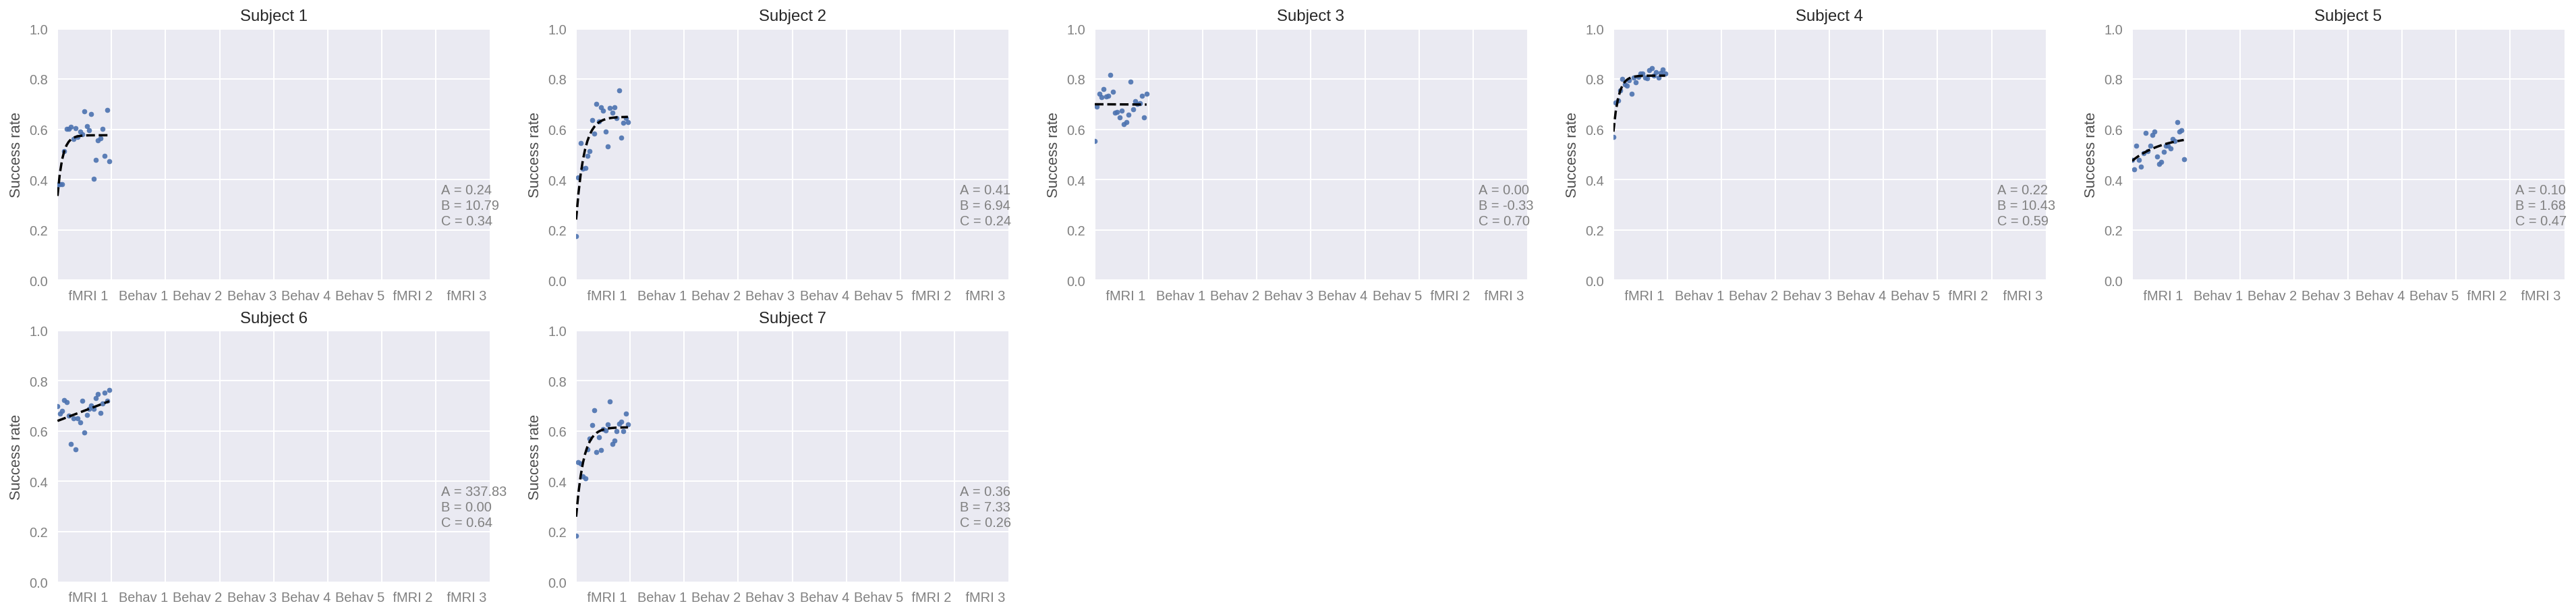

In [18]:
# figure for paper

fig, ax = plt.subplots()
fig.set_size_inches(33.3, 24)
fit_results = []

plt.style.use('seaborn')

for i, subj in enumerate(subj_list):
    
    sub_df = df[df['subj'] == subj]
    x = list(sub_df['x'])
    y = list(sub_df['y'])
    
    popt, pcov = scipy.optimize.curve_fit(exponential_fit, x, y)
    
    plt.subplot(6, 5, i+1)
    plt.grid(True)
    plt.scatter(x, y, marker='.', alpha=0.9)
    plt.plot(x, exponential_fit(np.array(x), *popt), 'k--')
    plt.title('Subject %d' % (i+1))
    plt.text(7.1, 0.345, 'A = %.2f' % (popt[0]), fontsize=10, color=(0.5, 0.5, 0.5))
    plt.text(7.1, 0.2825, 'B = %.2f' % (popt[1]), fontsize=10, color=(0.5, 0.5, 0.5))
    plt.text(7.1, 0.22, 'C = %.2f' % (popt[2]), fontsize=10, color=(0.5, 0.5, 0.5))
    plt.ylim(0, 1)
    plt.xlim(0, 8)
    plt.ylabel('Success rate', color=(0.3, 0.3, 0.3))
    
    if i > 26:
        plt.xlabel('Session', color=(0.3, 0.3, 0.3))
        
    plt.yticks(color=(0.5, 0.5, 0.5))
    plt.xticks(np.arange(8),
               labels=['   fMRI 1', '  Behav 1', '  Behav 2', '  Behav 3',
                       '  Behav 4', '  Behav 5', '   fMRI 2', '   fMRI 3'],
               ha='left', fontsize='medium', color=(0.5, 0.5, 0.5))
    fit_results.append((popt, pcov))

plt.show()
#fig.savefig('20191122_curve-fitting.png', dpi=300)